# Finding a Good Value BMW: Predicting Re-Sale Prices (notebook III)

## Content of notebook: Linear Regression, including model tuning 

Note: The features that are part of the final model were selected through an iterative approach (e.g., by checking collinearity and statistical significance. Lasso and Ridge Regression for regularization did not improve the model and thus are not shown here.

In [134]:
%pylab inline
%matplotlib inline

import time
import datetime
import pickle
import copy
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy 

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Creating dummy variables

In [90]:
df_lrm_BMW116 = pickle.load(open('pickles/df_lrm_BMW116.pkl', 'rb'))
df_lrm_BMW116.head(3)

,price,mileage_km,horse_power_ps,car_age,doors_number,gears_type,prior_owners,cylinder_capacity,aircon,fuel_type,emission_class,emissions,avg_fuel_cons,fuel_cons_city,fuel_cons_highway
0,9260,123787,116,6.754278,5,Schaltgetriebe,1.0,1995.0,Klimaanlage,Diesel,Euro5,109.0,4.1,5.1,3.6
1,9395,127400,116,6.502396,3,Schaltgetriebe,2.0,1995.0,Klimaautomatik,Diesel,Euro5,114.0,4.3,5.3,3.8
2,9480,131255,136,7.668720,5,Automatik,1.0,1598.0,Klimaanlage,Benzin,Euro5,131.0,5.6,7.2,4.7


In [91]:
df_lrm_BMW116.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              517 non-null    int64  
 1   mileage_km         517 non-null    int64  
 2   horse_power_ps     517 non-null    int64  
 3   car_age            517 non-null    float64
 4   doors_number       517 non-null    object 
 5   gears_type         517 non-null    object 
 6   prior_owners       517 non-null    float64
 7   cylinder_capacity  517 non-null    float64
 8   aircon             517 non-null    object 
 9   fuel_type          517 non-null    object 
 10  emission_class     517 non-null    object 
 11  emissions          517 non-null    float64
 12  avg_fuel_cons      517 non-null    float64
 13  fuel_cons_city     517 non-null    float64
 14  fuel_cons_highway  517 non-null    float64
dtypes: float64(7), int64(3), object(5)
memory usage: 60.7+ KB


#### Overview of categorical variables

In [92]:
categorical_variables = list(df_lrm_BMW116.select_dtypes(include='object'))
categorical_variables

['doors_number', 'gears_type', 'aircon', 'fuel_type', 'emission_class']

**Note:** environmental_certificate was removed after analyzing correlations.

In [93]:
# Quick glance at frequencies of observations of categorical variables
for object in categorical_variables:
    print(df_lrm_BMW116[object].value_counts())
    print("")

5    471
3     46
Name: doors_number, dtype: int64

Schaltgetriebe    460
Automatik          57
Name: gears_type, dtype: int64

Klimaautomatik    392
Klimaanlage        83
Keine              42
Name: aircon, dtype: int64

Benzin    311
Diesel    206
Name: fuel_type, dtype: int64

Euro6    421
Euro5     96
Name: emission_class, dtype: int64



#### New dataframe with dummy variables

In [94]:
df_lrm1_BMW116 = pd.get_dummies(data = df_lrm_BMW116, drop_first=True) 
df_lrm1_BMW116.head(3)

,price,mileage_km,horse_power_ps,car_age,prior_owners,cylinder_capacity,emissions,avg_fuel_cons,fuel_cons_city,fuel_cons_highway,doors_number_5,gears_type_Schaltgetriebe,aircon_Klimaanlage,aircon_Klimaautomatik,fuel_type_Diesel,emission_class_Euro6
0,9260,123787,116,6.754278,1.0,1995.0,109.0,4.1,5.1,3.6,1,1,1,0,1,0
1,9395,127400,116,6.502396,2.0,1995.0,114.0,4.3,5.3,3.8,0,1,0,1,1,0
2,9480,131255,136,7.668720,1.0,1598.0,131.0,5.6,7.2,4.7,1,0,1,0,0,0


For the **categorical variables** for which dummies have been created, the following are set as **baseline**: 
* doors_number: 3
* gears_type: Automatik (English: automatic)
* aircon: Keine (English: none)
* fuel_type: Benzin (English: petrol)
* emission_class: Euro 5

### Examining features

In [95]:
# Generate a list of features
list_features = list(df_lrm1_BMW116.columns.drop('price'))
list_features

['mileage_km',
 'horse_power_ps',
 'car_age',
 'prior_owners',
 'cylinder_capacity',
 'emissions',
 'avg_fuel_cons',
 'fuel_cons_city',
 'fuel_cons_highway',
 'doors_number_5',
 'gears_type_Schaltgetriebe',
 'aircon_Klimaanlage',
 'aircon_Klimaautomatik',
 'fuel_type_Diesel',
 'emission_class_Euro6']

#### Descriptive statistics

In [96]:
df_lrm1_BMW116.describe()

,price,mileage_km,horse_power_ps,car_age,prior_owners,cylinder_capacity,emissions,avg_fuel_cons,fuel_cons_city,fuel_cons_highway,doors_number_5,gears_type_Schaltgetriebe,aircon_Klimaanlage,aircon_Klimaautomatik,fuel_type_Diesel,emission_class_Euro6
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,16614.955513,42135.874275,114.295938,3.170188,1.189555,1521.100775,116.037402,4.782178,5.887525,4.141188,0.911025,0.889749,0.160542,0.758221,0.398453,0.814313
std,5043.244328,28977.847897,7.699003,1.695959,0.416295,113.687648,11.219126,0.705762,1.085735,0.490497,0.284983,0.313506,0.367463,0.428576,0.490054,0.389230
min,9260.000000,10.000000,109.000000,0.084873,1.000000,4.000000,89.000000,3.400000,3.900000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13900.000000,20483.000000,109.000000,2.168378,1.000000,1496.000000,107.000000,4.100000,4.700000,3.600000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,15300.000000,37666.000000,109.000000,3.167693,1.000000,1499.000000,116.000000,5.000000,6.300000,4.200000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,17795.000000,58518.000000,116.000000,3.501711,1.000000,1499.000000,123.000000,5.300000,6.700000,4.500000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,38797.000000,149840.000000,136.000000,7.920602,3.000000,1995.000000,140.000000,5.900000,7.500000,5.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The descriptive statistics appears plausible. 

#### Reviewing correlations

In [97]:
df_lrm1_BMW116.corr()

,price,mileage_km,horse_power_ps,car_age,prior_owners,cylinder_capacity,emissions,avg_fuel_cons,fuel_cons_city,fuel_cons_highway,doors_number_5,gears_type_Schaltgetriebe,aircon_Klimaanlage,aircon_Klimaautomatik,fuel_type_Diesel,emission_class_Euro6
price,1.000000,-0.627055,-0.138555,-0.746110,-0.223319,-0.211317,-0.177876,-0.247719,-0.302104,-0.191732,0.135104,-0.231498,-0.235848,0.192436,0.356720,-0.008146
mileage_km,-0.627055,1.000000,0.364864,0.647082,0.215365,0.318309,-0.145833,-0.143496,-0.104210,-0.183388,-0.093639,-0.043550,0.225968,-0.124416,0.115272,-0.171328
horse_power_ps,-0.138555,0.364864,1.000000,0.575797,0.206189,0.254239,-0.022511,-0.116752,-0.088868,-0.102457,-0.122234,-0.158280,0.345549,-0.182079,0.180312,-0.481533
car_age,-0.746110,0.647082,0.575797,1.000000,0.338590,0.429007,0.162690,0.175513,0.246916,0.122094,-0.117982,0.084474,0.392683,-0.307275,-0.252771,-0.378963
prior_owners,-0.223319,0.215365,0.206189,0.338590,1.000000,0.208719,0.024760,-0.002070,0.021911,-0.009166,-0.069923,0.011948,0.142738,-0.057631,-0.009959,-0.212926
cylinder_capacity,-0.211317,0.318309,0.254239,0.429007,0.208719,1.000000,0.083679,0.011955,0.046505,0.008354,-0.085619,-0.031333,0.211660,-0.144081,0.075356,-0.439332
emissions,-0.177876,-0.145833,-0.022511,0.162690,0.024760,0.083679,1.000000,0.958876,0.940133,0.971203,-0.029309,0.265100,0.105791,-0.119495,-0.805637,-0.161857
avg_fuel_cons,-0.247719,-0.143496,-0.116752,0.175513,-0.002070,0.011955,0.958876,1.000000,0.988918,0.979563,-0.038389,0.322186,0.098433,-0.151342,-0.913247,-0.062564
fuel_cons_city,-0.302104,-0.104210,-0.088868,0.246916,0.021911,0.046505,0.940133,0.988918,1.000000,0.964459,-0.047282,0.361048,0.132904,-0.188187,-0.934557,-0.076058
fuel_cons_highway,-0.191732,-0.183388,-0.102457,0.122094,-0.009166,0.008354,0.971203,0.979563,0.964459,1.000000,-0.033104,0.265483,0.086325,-0.121679,-0.857205,-0.067165


In [98]:
df_lrm1_BMW116.corr()['price'].sort_values(ascending=False)

price                        1.000000
fuel_type_Diesel             0.356720
aircon_Klimaautomatik        0.192436
doors_number_5               0.135104
emission_class_Euro6        -0.008146
horse_power_ps              -0.138555
emissions                   -0.177876
fuel_cons_highway           -0.191732
cylinder_capacity           -0.211317
prior_owners                -0.223319
gears_type_Schaltgetriebe   -0.231498
aircon_Klimaanlage          -0.235848
avg_fuel_cons               -0.247719
fuel_cons_city              -0.302104
mileage_km                  -0.627055
car_age                     -0.746110
Name: price, dtype: float64

### Removing features

Please note: Features were removed in an iterative approach - also taking into consideration the heratmap shown and pairplot displayed further down.

**Conclusion 1:** Excluding the following variables from the model as they seem to have no correlation with the target variable:

  * fuel_type_Diesel
  * emission_class_Euro6

**Conclusion 2:** Excluding the following variables from the model due to a very high level of collinearity:
  * fuel_cons_city
  * avg_fuel_cons
  * emissions

In [99]:
list_features

['mileage_km',
 'horse_power_ps',
 'car_age',
 'prior_owners',
 'cylinder_capacity',
 'emissions',
 'avg_fuel_cons',
 'fuel_cons_city',
 'fuel_cons_highway',
 'doors_number_5',
 'gears_type_Schaltgetriebe',
 'aircon_Klimaanlage',
 'aircon_Klimaautomatik',
 'fuel_type_Diesel',
 'emission_class_Euro6']

In [100]:
variables_to_remove = ['fuel_type_Diesel','emission_class_Euro6','fuel_cons_city','avg_fuel_cons', 'emissions']

In [101]:
for variable in variables_to_remove:
    list_features.remove(variable)

In [103]:
list_features.append('price')

In [104]:
df_lrm2_BMW116 = df_lrm1_BMW116.loc[:, list_features].copy()
df_lrm2_BMW116

,mileage_km,horse_power_ps,car_age,prior_owners,cylinder_capacity,fuel_cons_highway,doors_number_5,gears_type_Schaltgetriebe,aircon_Klimaanlage,aircon_Klimaautomatik,price
0,123787,116,6.754278,1.0,1995.0,3.6,1,1,1,0,9260
1,127400,116,6.502396,2.0,1995.0,3.8,0,1,0,1,9395
2,131255,136,7.668720,1.0,1598.0,4.7,1,0,1,0,9480
3,111655,116,5.418207,3.0,1995.0,3.8,1,1,1,0,9580
4,75450,136,7.668720,3.0,1598.0,4.6,1,1,1,0,9850
...,...,...,...,...,...,...,...,...,...,...,...
512,5453,116,0.418891,1.0,1496.0,3.8,1,1,0,1,35299
513,8600,116,0.336756,1.0,1496.0,3.0,1,1,0,1,35490
514,444,116,0.418891,1.0,1496.0,3.5,1,0,0,1,36480
515,5100,116,0.084873,1.0,1496.0,4.1,1,0,0,1,36690


**Use heatmap to check that there are no more highly collinear features or features lacking correlation with target in the model:**

<AxesSubplot:>

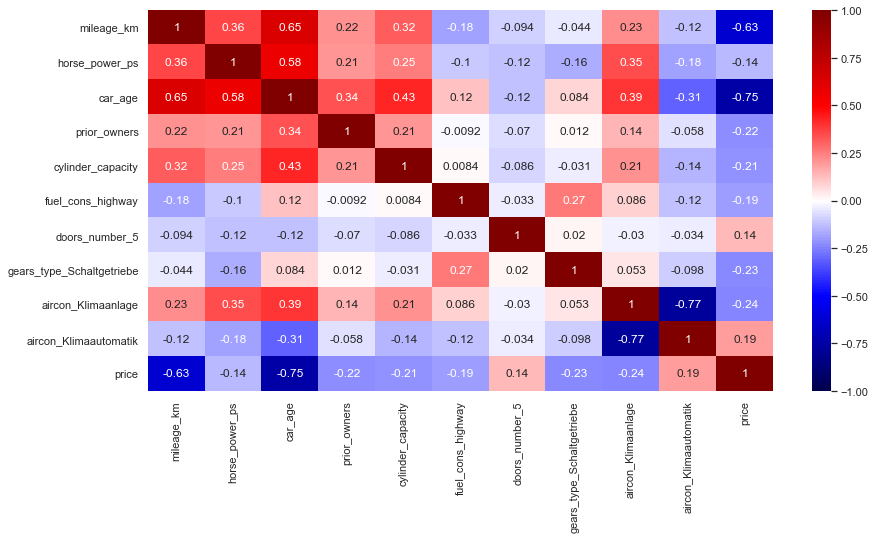

In [105]:
plt.figure(figsize = [14,7])
sns.heatmap(df_lrm2_BMW116.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

In [106]:
# Commenting generation of pairplot out because it takes long to load.
# sns_pairplot_BMW116 = sns.pairplot(df_lrm2_BMW116)

In [107]:
# sns_pairplot_BMW116.savefig("sns_pairplot_BMW116.png")

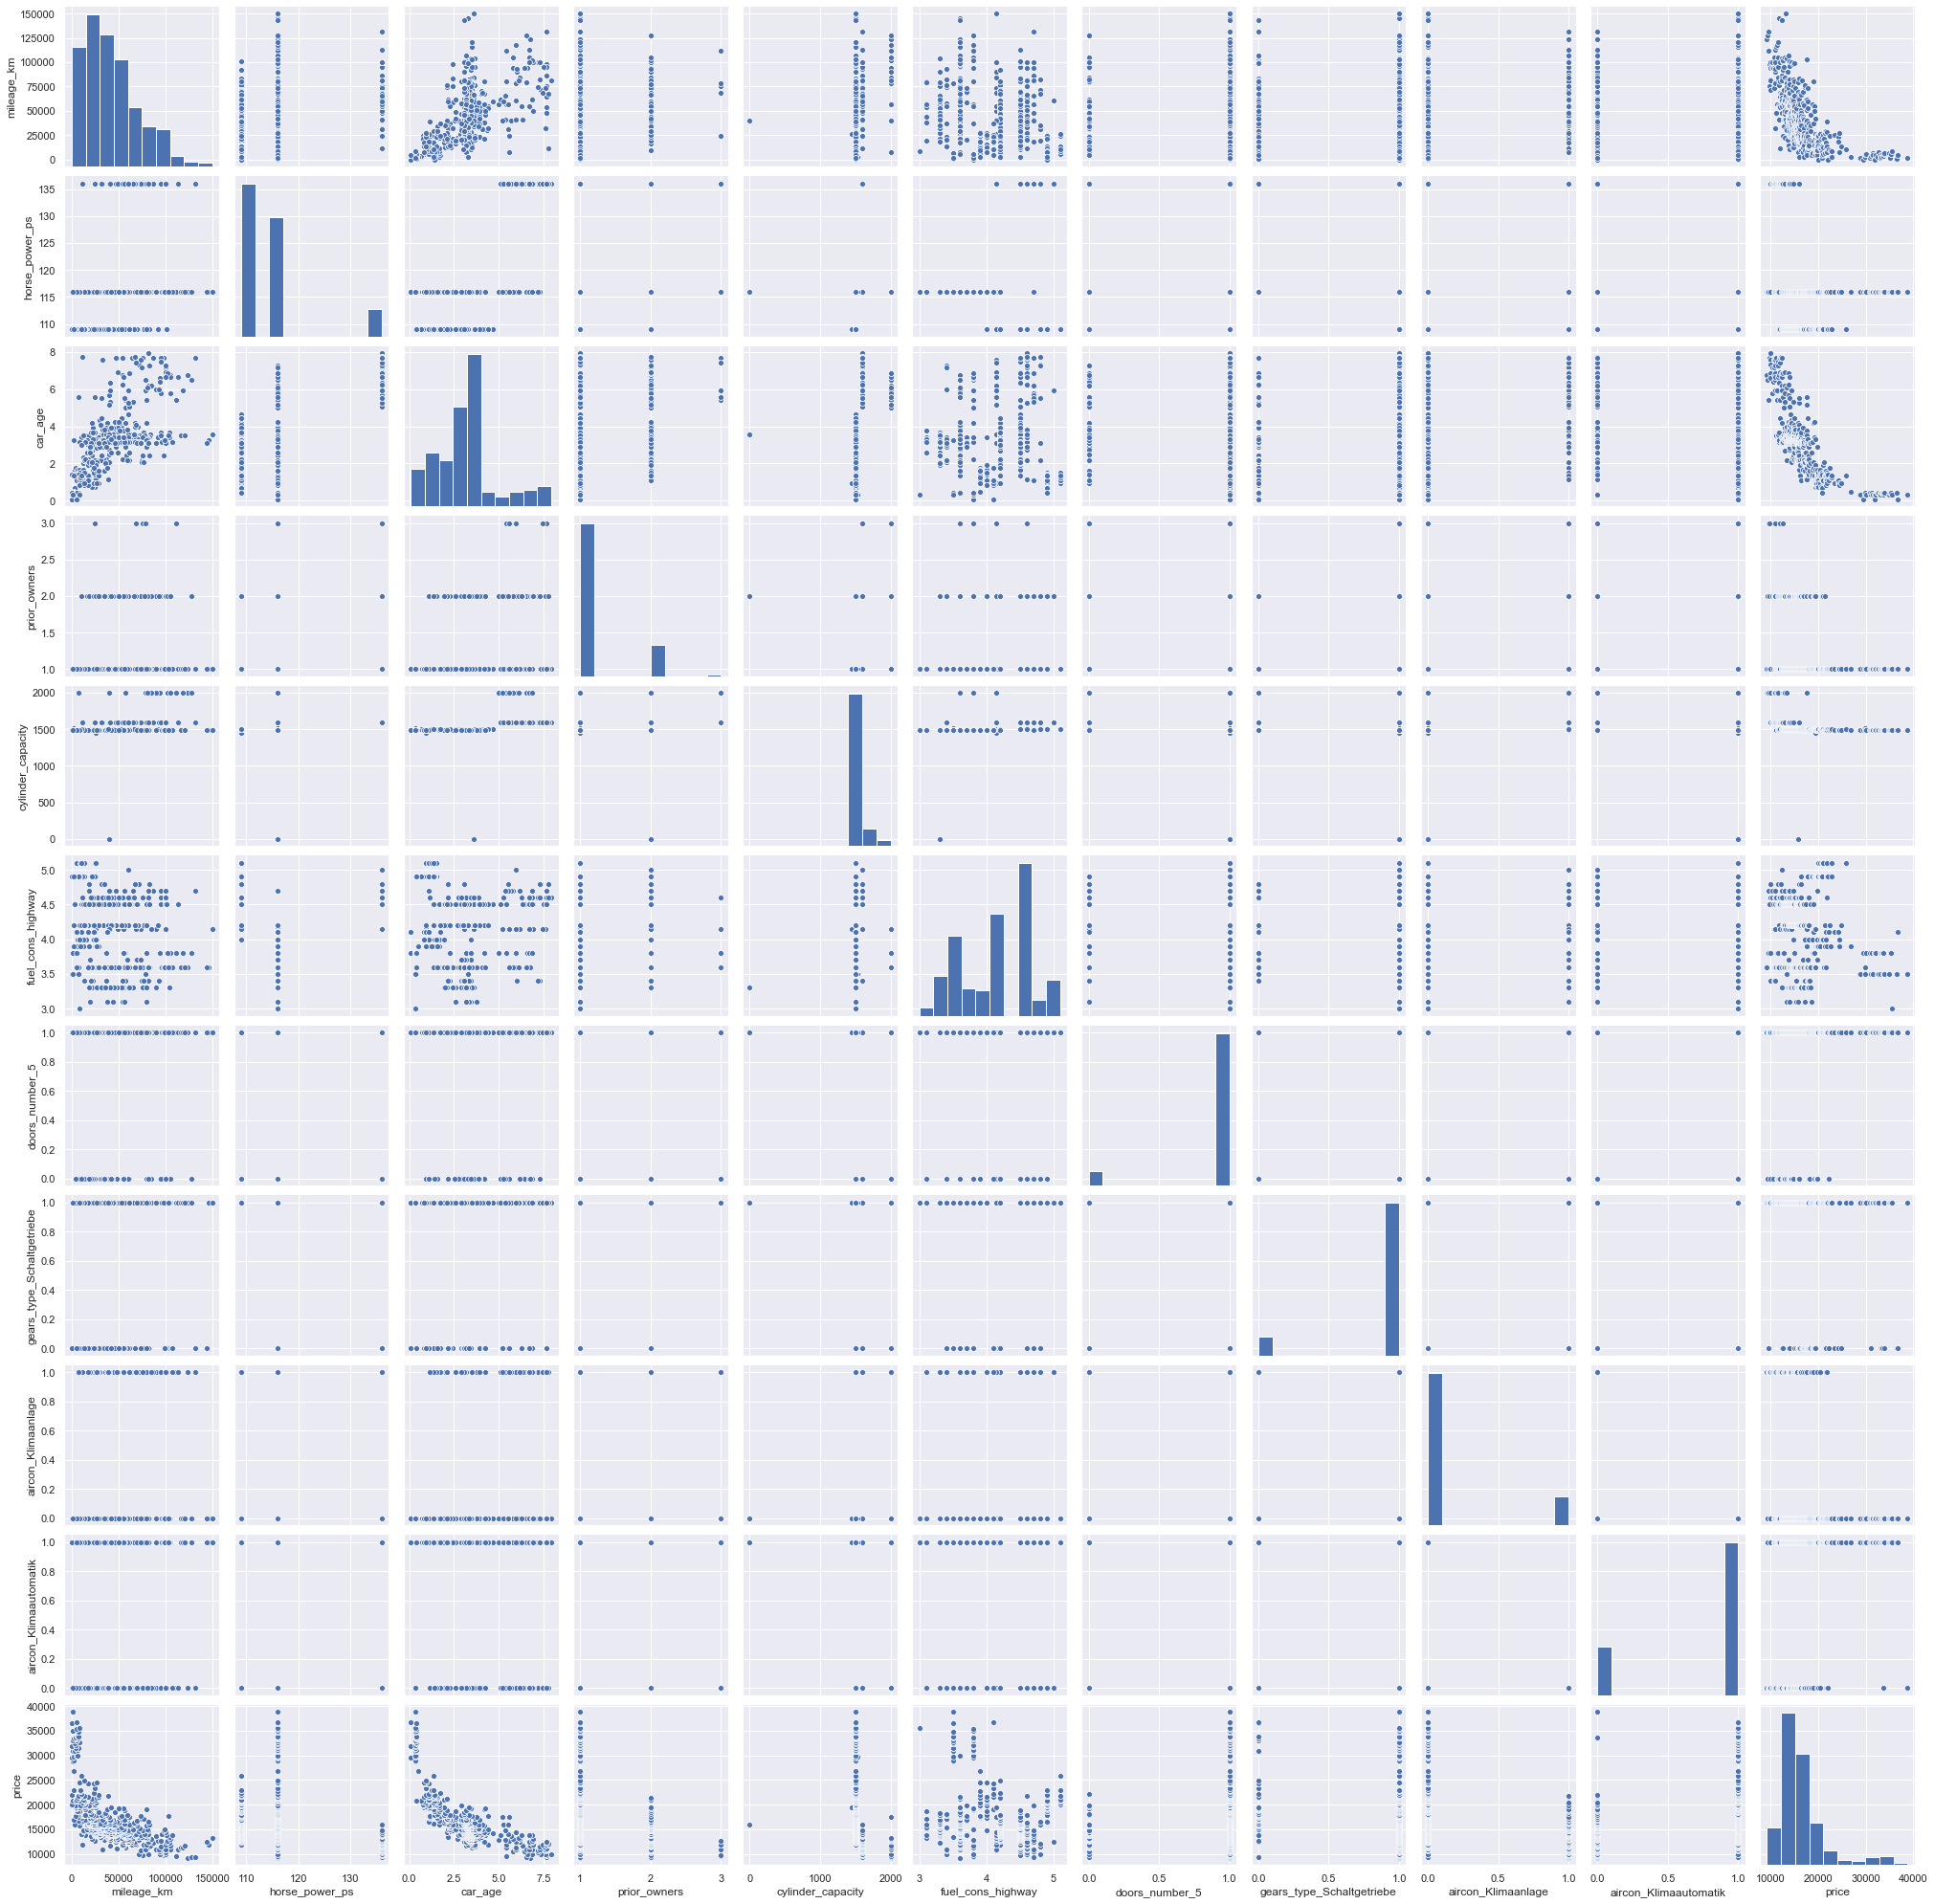

In [108]:
from IPython.display import Image
Image("sns_pairplot_BMW116.png")

### Part First Simple Linear Regression Model

In [109]:
list_features

['mileage_km',
 'horse_power_ps',
 'car_age',
 'prior_owners',
 'cylinder_capacity',
 'fuel_cons_highway',
 'doors_number_5',
 'gears_type_Schaltgetriebe',
 'aircon_Klimaanlage',
 'aircon_Klimaautomatik',
 'price']

In [110]:
# create a string that defines the model (to avoide typing the variable names)
list_features.remove('price')
model_definition = "price ~ "

for feature in list_features:
    model_definition += str(feature)
    model_definition += " + "

In [111]:
# This removes the last " + " at the end of the string
model_definition = model_definition[:len(model_definition)-3]

In [112]:
model_definition

'price ~ mileage_km + horse_power_ps + car_age + prior_owners + cylinder_capacity + fuel_cons_highway + doors_number_5 + gears_type_Schaltgetriebe + aircon_Klimaanlage + aircon_Klimaautomatik'

In [113]:
# Feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(model_definition, data=df_lrm2_BMW116, return_type="dataframe")

# Create separate dataset for training, vaidation and testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

# Create your model
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     93.09
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           1.52e-85
Time:                        21:59:24   Log-Likelihood:                -2863.2
No. Observations:                 309   AIC:                             5748.
Df Residuals:                     298   BIC:                             5789.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -7082.5069   3919.224     -1.807      0.072   -1.48e+04     630.356
mileage_km                   -0.0521      0.007     -7.329      0.000      -0.066      -0.038
horse_power_ps              270.2973     25.149     10.748      0.000     220.806     319.789
car_age                   -2428.4706    159.720    -15.205      0.000   -2742.793   -2114.148
prior_owners                249.0405    378.132      0.659      0.511    -495.107     993.188
cylinder_capacity             5.0387      1.269      3.970      0.000       2.541       7.536
fuel_cons_highway         -1140.5076    354.917     -3.213      0.001   -1838.969    -442.047
doors_number_5             1367.7772    515.924      2.651      0.008     352.461    2383.094
gears_type_Schaltgetriebe -1277.5727    502.290     -2.543      0.011   -2266.057    -289.088
aircon_Klimaanlage         -521.7483    679.923     -0.767      0.443   -1859.807     816.311
aircon_Klimaautomatik      -610.2922    575.011     -1.061      0.289   -1741.889     521.305
==============================================================================
Omnibus:                       75.019   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.496
Skew:                           1.178   Prob(JB):                     1.28e-38
Kurtosis:                       5.828   Cond. No.                     1.40e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Insights:** 

  1) 'aircon_Klinaautimatik' and 'aircon_Klimaanlage' are highly collinear -> combine them within one variable and check if combined feature becomes significant
  
  2) 'prior_owners' is not significant -> exclude the feature
 
  3) Target 'price' is left skewed, log-transform it
  
  4) 'mileage_km' is convex, Itransform it
  
  5) 'emissions' is not significant (this turned out after having done feature engineering steps 1-4), so they are also excluded in the final model
  
  6) 'cylinder_capacity' is not significant (this turned out after having done feature engineering steps 1-5), so they are also excluded from the final model

### Feature Engineering

Create a new dataframe with the transformed variables.

**1) Combine aircon_Klimaautimatik and aircon_Klimaanlage into one variable:**

In [114]:
df_lrm3_BMW116 = df_lrm2_BMW116.copy()

In [115]:
df_lrm3_BMW116['aircon'] = df_lrm3_BMW116['aircon_Klimaanlage'] + df_lrm3_BMW116['aircon_Klimaautomatik']

**2), 5) and 6) Excluding prior_owners, emissions and cylinder_capacity: done within model definition below**

**3) Log-transformation of dependent variable 'price'**

<AxesSubplot:>

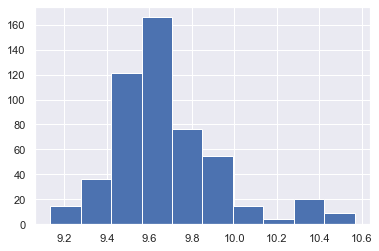

In [116]:
np.log(df_lrm3_BMW116.price).hist()

The log-transformed target looks more bell-shaped.

In [117]:
df_lrm3_BMW116['price_log']= np.log(df_lrm3_BMW116.price)

**4) Box Cox transformation of independent variable 'mileage'**

Histrogram of feature to identify suitable transformation:

<AxesSubplot:>

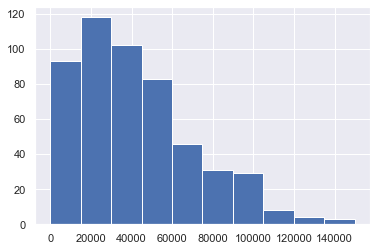

In [119]:
df_lrm3_BMW116.mileage_km.hist()

**Try Box Cox transformation:**

In [123]:
lamb=stats.boxcox_normmax(df_lrm3_BMW116.mileage_km, brack=(-1.9, 1.9), method = 'mle')
print("Lambda:", lamb)

Lambda: 0.48467235987582874


(array([ 12.,  27.,  40.,  72.,  99., 100.,  86.,  48.,  27.,   6.]),
 array([  4.23506158,  70.13797965, 136.04089771, 201.94381578,
        267.84673384, 333.7496519 , 399.65256997, 465.55548803,
        531.4584061 , 597.36132416, 663.26424223]),
 <BarContainer object of 10 artists>)

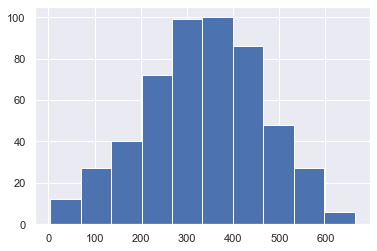

In [124]:
df_lrm3_BMW116['mileage_transformed'] =(np.power(df_lrm3_BMW116.mileage_km,lamb)-1)/lamb

plt.hist(df_lrm3_BMW116.mileage_transformed)

**Conclusion:** The Box Cox Transformation gave the R Square another 0.02 Boost!

In [125]:
with open('pickles/df_lrm3_BMW116.pkl', 'wb') as f:
    pickle.dump(df_lrm3_BMW116, f)

## OLS model after feature engineering

In [126]:
df_enigneered = pickle.load(open('pickles/df_lrm3_BMW116.pkl', 'rb'))

In [127]:
variables_engineered = list(df_enigneered.columns)
variables_engineered

['mileage_km',
 'horse_power_ps',
 'car_age',
 'prior_owners',
 'cylinder_capacity',
 'fuel_cons_highway',
 'doors_number_5',
 'gears_type_Schaltgetriebe',
 'aircon_Klimaanlage',
 'aircon_Klimaautomatik',
 'price',
 'aircon',
 'price_log',
 'mileage_squared',
 'mileage_transformed']

In [128]:
variables_to_remove = ['price', 'price_log', 'mileage_km', 'prior_owners', 'cylinder_capacity', 'aircon_Klimaanlage',
 'aircon_Klimaautomatik', 'aircon', 'mileage_squared']

*Note: Feature 'aircon' is also removed due to lack of statistical significance*

In [129]:
for variable in variables_to_remove:
    variables_engineered.remove(variable)

In [130]:
# create a string that defines the model (to avoide typing the variable names)
model_definition_engineered = "price_log ~ "

for feature in variables_engineered:
    model_definition_engineered += str(feature)
    model_definition_engineered += " + "

In [131]:
model_definition_engineered = model_definition_engineered[:len(model_definition_engineered)-3]

In [132]:
# Creating feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(model_definition_engineered, data=df_enigneered, return_type="dataframe")

# hold out 20% of the data for final testing, random states fixes the random sample
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=7)

# Create OLS model
model = sm.OLS(y_train,X_train)

# Fit model to training set
model = model.fit()

# Print summary statistics of the model's performance
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     278.4
Date:                Tue, 10 Nov 2020   Prob (F-statistic):          7.10e-120
Time:                        21:59:31   Log-Likelihood:                 270.39
No. Observations:                 309   AIC:                            -526.8
Df Residuals:                     302   BIC:                            -500.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     9.6969      0.138     70.366      0.000       9.426       9.968
horse_power_ps                0.0076      0.001      7.640      0.000       0.006       0.010
car_age                      -0.0945      0.006    -16.323      0.000      -0.106      -0.083
fuel_cons_highway            -0.0625      0.014     -4.530      0.000      -0.090      -0.035
doors_number_5                0.0583      0.019      2.998      0.003       0.020       0.097
gears_type_Schaltgetriebe    -0.1047      0.019     -5.564      0.000      -0.142      -0.068
mileage_transformed          -0.0009    6.7e-05    -12.805      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       20.473   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.833
Skew:                           0.606   Prob(JB):                     1.10e-05
Kurtosis:                       3.551   Cond. No.                     8.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Conclusion:**    

  * R square is good (cross validation below)
  * All coefficients statistically significant
  * Omnibus: Residuals are normally distributed since it is greater 0.05
  * Skew okayish (should be zero)
  * Kurtosis okyish (should be 3)
  * Durbin-Watson: errors might be slightly auto-correlated
 

### Look into training data only: ###

In [135]:
# reverse log-transformation of target variable
y_train_rev = np.e**y_train
y_pred_train_rev = np.e**model.predict(X_train)

"""
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(16,6))
plt.scatter(y_train_rev, y_pred_on_train_rev)
plt.title('Predicted prices vs. actual prices (basis: training dataset)', fontsize=20)
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices');
"""

"\n# Use statsmodels to plot the residuals vs the fitted values\nplt.figure(figsize=(16,6))\nplt.scatter(y_train_rev, y_pred_on_train_rev)\nplt.title('Predicted prices vs. actual prices (basis: training dataset)', fontsize=20)\nplt.xlabel('Actual prices')\nplt.ylabel('Predicted prices');\n"

In [141]:
y_true = y_train_rev
y_pred = y_pred_train_rev 
print('The square root of MSE in the TEST dataset is: {}. I.e., on average, the predicted value is this much off.'.format(mean_squared_error(y_true, y_pred)**0.5))
print()
print('MAE in the TEST dataset is: {}'.format(mean_absolute_error(y_true, y_pred)))

The square root of MSE in the TEST dataset is: 2040.2724102742843. I.e., on average, the predicted value is this much off.

MAE in the TEST dataset is: 1370.118661238763


### Use model to predict prices in validation dataset: ###

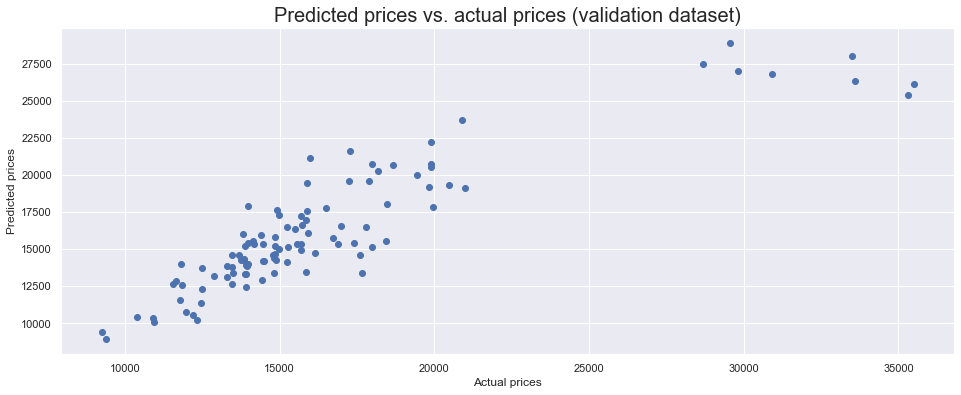

In [142]:
# reverse log-transformation of target variable
y_val_true = np.e**y_val
y_val_pred = np.e**model.predict(X_val)

# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(16,6))
plt.scatter(y_val_true, y_val_pred)
plt.title('Predicted prices vs. actual prices (validation dataset)', fontsize=20)
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices');

In [143]:
y_true = y_val_true
y_pred = y_val_pred 
print('The square root of MSE in validation dataset is: {}'.format(mean_squared_error(y_val_true, y_val_pred)**0.5))
print()
print('I.e., on average, the predicted value is this much off.')
print()
print('MAE in validation dataset is: {}'.format(mean_absolute_error(y_val_true, y_val_pred)))

The square root of MSE in validation dataset is: 2302.92571520955

I.e., on average, the predicted value is this much off.

MAE in validation dataset is: 1550.5285484942046


In [144]:
X_val.shape

(104, 7)

### Use training and validation datasets to retrain model ###

In [145]:
# model was defined above, the only change here is that I include the validation dataset in model training (X comprises X_train and X_val)
model_retrained = sm.OLS(y,X)
model_retrained = model_retrained.fit()
model_retrained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     356.7
Date:                Tue, 10 Nov 2020   Prob (F-statistic):          1.98e-158
Time:                        22:24:33   Log-Likelihood:                 351.13
No. Observations:                 413   AIC:                            -688.3
Df Residuals:                     406   BIC:                            -660.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     9.5233      0.121     78.704      0.000       9.285       9.761
horse_power_ps                0.0087      0.001      9.997      0.000       0.007       0.010
car_age                      -0.0967      0.005    -18.298      0.000      -0.107      -0.086
fuel_cons_highway            -0.0494      0.012     -4.147      0.000      -0.073      -0.026
doors_number_5                0.0628      0.018      3.428      0.001       0.027       0.099
gears_type_Schaltgetriebe    -0.1111      0.017     -6.509      0.000      -0.145      -0.078
mileage_transformed          -0.0008   5.92e-05    -14.131      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       24.194   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.868
Skew:                           0.549   Prob(JB):                     8.88e-07
Kurtosis:                       3.644   Cond. No.                     8.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

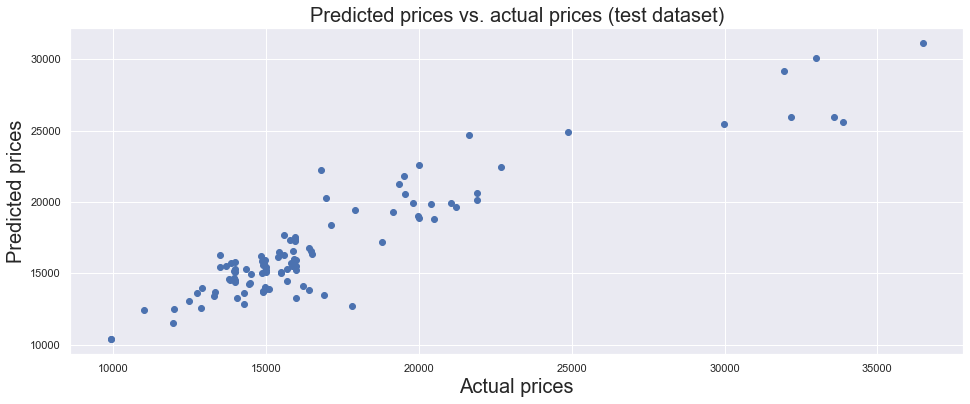

In [146]:
# reverse log-transformation of target variable
y_test_true = np.e**y_test
y_test_pred = np.e**model_retrained.predict(X_test)

# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(16,6))
plt.scatter(y_test_true, y_test_pred)
plt.title('Predicted prices vs. actual prices (test dataset)', fontsize=20)
plt.xlabel('Actual prices', fontsize=20)
plt.ylabel('Predicted prices', fontsize=20);

In [39]:
y_true = np.exp(y_test)
y_pred = np.exp(model.predict(X_test))
print('MSE in test dataset is: {}'.format((mean_squared_error(y_true, y_pred)**0.5)))
print('MAE in test dataset is: {}'.format(mean_absolute_error(y_true, y_pred)))

MSE in test dataset is: 2139.4461934662017
MAE in test dataset is: 1440.5959476120468


In [38]:
# For comparison: MSE and MAE in validation dataset
y_true = np.exp(y_val)
y_pred = np.exp(model.predict(X_val))
print('MSE in validation dataset is: {}'.format((mean_squared_error(y_true, y_pred)**0.5)))
print('MAE in validation dataset is: {}'.format(mean_absolute_error(y_true, y_pred)))

MSE in validation dataset is: 2379.942288780096
MAE in validation dataset is: 1610.5103375035217


Actually, MSE in test dataset is lower than in valudation dataset. 

**Conclusion:** The model works very well in predicting the prices of used cars. But it is systematically off for the very expensive cars. Let's see the model KPIs if only applied to less expensive cars.

## Applying OLS to inexpensive cars

### Analyzing characertistics of highly expensive cars (not suitable for OLS prediction)

In [148]:
df_enigneered = pickle.load(open('pickles/df_lrm3_BMW116.pkl', 'rb'))
df_expensive_cars = df_enigneered.loc[df_enigneered['price']>= 30000,:].copy()

In [41]:
df_expensive_cars.describe()

,index,price,mileage_km,horse_power_ps,car_age,prior_owners,cylinder_capacity,emissions,avg_fuel_cons,fuel_cons_city,fuel_cons_highway
count,25.000000,25.00000,25.000000,25.0,25.0,25.0,25.0,25.000000,25.000000,25.000000,25.000000
mean,504.000000,33499.76000,4130.080000,116.0,0.0,1.0,1496.0,106.440000,4.016000,4.652000,3.636000
std,7.359801,1981.70857,2498.550095,0.0,0.0,0.0,0.0,6.621178,0.230362,0.348951,0.217715
min,492.000000,30900.00000,10.000000,116.0,0.0,1.0,1496.0,100.000000,3.800000,4.000000,3.000000
25%,498.000000,31950.00000,1500.000000,116.0,0.0,1.0,1496.0,100.000000,3.800000,4.500000,3.500000
50%,504.000000,33370.00000,4200.000000,116.0,0.0,1.0,1496.0,109.000000,4.000000,4.500000,3.500000
75%,510.000000,34790.00000,6000.000000,116.0,0.0,1.0,1496.0,110.000000,4.200000,4.900000,3.800000
max,516.000000,38797.00000,8600.000000,116.0,0.0,1.0,1496.0,122.000000,4.600000,5.800000,4.100000


**Conclustion:** 
Here, features of cars costing over 30k Euros are shown. We see that overall, there are 25 cars that are advertised at a price above 30k EUR. 
These are all very new cars (age less than 1 year). Average mileage is 4130 km, i.e. very little and there is only one prior owner. Also, there is little variation in the other feature values.

Please note that the value of a brand new BMW118 (next more expensive model) without any fancy extras is 28,300 EUR! 
Thus, the variation must come from other sources such as extras which are not systematically captured on the website! 

### OLS on reduced dataset (exclude highly expensive cars)

In [152]:
df_inexpensive_cars = df_enigneered.loc[df_enigneered['price'] < 30000,:].copy()

In [153]:
# Creating feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(model_definition_engineered, data=df_inexpensive_cars, return_type="dataframe")

# hold out 20% of the data for final testing, random states fixes the random sample
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=7)

# Create OLS model
model = sm.OLS(y_train,X_train)

# Fit model to training set
model = model.fit()

# Print summary statistics of the model's performance
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     220.3
Date:                Tue, 10 Nov 2020   Prob (F-statistic):          2.60e-104
Time:                        22:41:45   Log-Likelihood:                 320.93
No. Observations:                 294   AIC:                            -627.9
Df Residuals:                     287   BIC:                            -602.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     9.6258      0.112     86.222      0.000       9.406       9.846
horse_power_ps                0.0052      0.001      6.303      0.000       0.004       0.007
car_age                      -0.0831      0.005    -15.952      0.000      -0.093      -0.073
fuel_cons_highway            -0.0044      0.011     -0.393      0.694      -0.027       0.018
doors_number_5                0.0571      0.017      3.290      0.001       0.023       0.091
gears_type_Schaltgetriebe    -0.1246      0.017     -7.476      0.000      -0.157      -0.092
mileage_transformed          -0.0007   6.01e-05    -10.951      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        2.496   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.443
Skew:                           0.223   Prob(JB):                        0.295
Kurtosis:                       2.966   Cond. No.                     8.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Conclusion:**    

  * R square is good (cross validation below)
  * All coefficients statistically significant
  * Omnibus: Residuals are normally distributed since it is greater 0.05
  * Skew okayish (should be zero)
  * Kurtosis okyish (should be 3)
  * Durbin-Watson: errors might be slightly auto-correlated
 

### Look into training data only: ###

In [154]:
# reverse log-transformation of target variable
y_train_rev = np.e**y_train
y_pred_train_rev = np.e**model.predict(X_train)

"""
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(16,6))
plt.scatter(y_train_rev, y_pred_on_train_rev)
plt.title('Predicted prices vs. actual prices (basis: training dataset)', fontsize=20)
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices');
"""

"\n# Use statsmodels to plot the residuals vs the fitted values\nplt.figure(figsize=(16,6))\nplt.scatter(y_train_rev, y_pred_on_train_rev)\nplt.title('Predicted prices vs. actual prices (basis: training dataset)', fontsize=20)\nplt.xlabel('Actual prices')\nplt.ylabel('Predicted prices');\n"

In [155]:
y_true = y_train_rev
y_pred = y_pred_train_rev 
print('The square root of MSE in the TEST dataset is: {}. I.e., on average, the predicted value is this much off.'.format(mean_squared_error(y_true, y_pred)**0.5))
print()
print('MAE in the TEST dataset is: {}'.format(mean_absolute_error(y_true, y_pred)))

The square root of MSE in the TEST dataset is: 1309.5785097106318. I.e., on average, the predicted value is this much off.

MAE in the TEST dataset is: 1021.1885722443698


### Use model to predict prices in validation dataset: ###

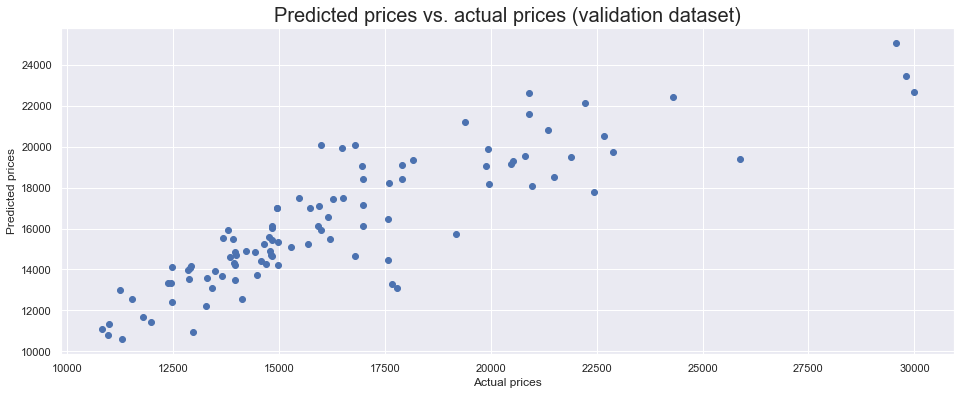

In [156]:
# reverse log-transformation of target variable
y_val_true = np.e**y_val
y_val_pred = np.e**model.predict(X_val)

# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(16,6))
plt.scatter(y_val_true, y_val_pred)
plt.title('Predicted prices vs. actual prices (validation dataset)', fontsize=20)
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices');

In [157]:
y_true = y_val_true
y_pred = y_val_pred 
print('The square root of MSE in validation dataset is: {}'.format(mean_squared_error(y_val_true, y_val_pred)**0.5))
print()
print('I.e., on average, the predicted value is this much off.')
print()
print('MAE in validation dataset is: {}'.format(mean_absolute_error(y_val_true, y_val_pred)))

The square root of MSE in validation dataset is: 2044.4234670336818

I.e., on average, the predicted value is this much off.

MAE in validation dataset is: 1437.406982252385


### Use training and validation datasets to retrain model ###

In [158]:
# model was defined above, the only change here is that I include the validation dataset in model training (X comprises X_train and X_val)
model_retrained = sm.OLS(y,X)
model_retrained = model_retrained.fit()
model_retrained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     269.9
Date:                Tue, 10 Nov 2020   Prob (F-statistic):          9.72e-135
Time:                        22:43:20   Log-Likelihood:                 395.14
No. Observations:                 393   AIC:                            -776.3
Df Residuals:                     386   BIC:                            -748.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     9.5239      0.107     88.926      0.000       9.313       9.734
horse_power_ps                0.0062      0.001      7.867      0.000       0.005       0.008
car_age                      -0.0879      0.005    -18.875      0.000      -0.097      -0.079
fuel_cons_highway            -0.0086      0.011     -0.809      0.419      -0.029       0.012
doors_number_5                0.0603      0.016      3.671      0.000       0.028       0.093
gears_type_Schaltgetriebe    -0.1107      0.015     -7.194      0.000      -0.141      -0.080
mileage_transformed          -0.0006   5.29e-05    -12.141      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       19.159   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.393
Skew:                           0.490   Prob(JB):                     2.26e-05
Kurtosis:                       3.587   Cond. No.                     9.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

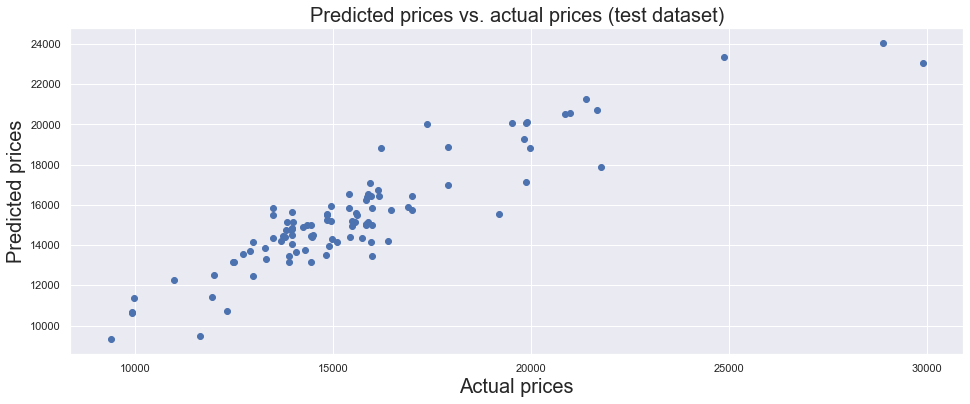

In [159]:
# reverse log-transformation of target variable
y_test_true = np.e**y_test
y_test_pred = np.e**model_retrained.predict(X_test)

# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(16,6))
plt.scatter(y_test_true, y_test_pred)
plt.title('Predicted prices vs. actual prices (test dataset)', fontsize=20)
plt.xlabel('Actual prices', fontsize=20)
plt.ylabel('Predicted prices', fontsize=20);

In [160]:
y_true = np.exp(y_test)
y_pred = np.exp(model.predict(X_test))
print('MSE in test dataset is: {}'.format((mean_squared_error(y_true, y_pred)**0.5)))
print('MAE in test dataset is: {}'.format(mean_absolute_error(y_true, y_pred)))

MSE in test dataset is: 1457.3348625504302
MAE in test dataset is: 1007.0535238199675


In [161]:
# For comparison: MSE and MAE in validation dataset
y_true = np.exp(y_val)
y_pred = np.exp(model.predict(X_val))
print('MSE in validation dataset is: {}'.format((mean_squared_error(y_true, y_pred)**0.5)))
print('MAE in validation dataset is: {}'.format(mean_absolute_error(y_true, y_pred)))

MSE in validation dataset is: 2044.423467033683
MAE in validation dataset is: 1437.4069822523852


Actually, MSE in test dataset is lower than in valudation dataset. 

**Conclusion:** The model works very well in predicting the prices of used cars - especially the ones that are really used (and thus not highly expensive).

## Appendix: Checking assumptions

In [64]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)
    
    plt.subplot(1, 2, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

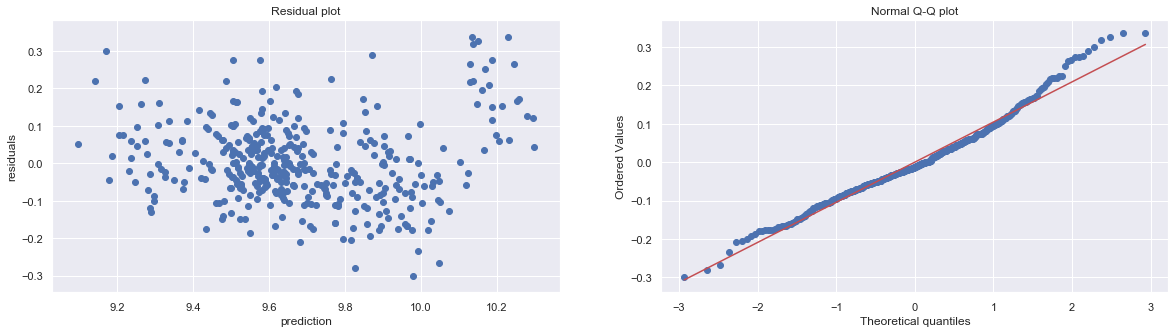

In [65]:
diagnostic_plot(X, y) 